In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## MetroMap Implementation

### 1. Read computed SOM

In [2]:
from SOMToolBoxParser import SOMToolBoxParser

input_vectors = SOMToolBoxParser("datasets/iris/iris.vec").read_weight_file()
weight_vectors = SOMToolBoxParser("datasets/iris/iris.wgt.gz").read_weight_file()

### 2.a Component Planes

For each unit, take the weight vector of the corresponding attribute

In [3]:
## TODO: figure out shape of the input weight matrix: attr,x,y or attr,y,x
## TODO: last argument of .reshape

component_planes = np.array([weight_vectors['arr'][:, i] for i in range(weight_vectors['vec_dim'])]).reshape(
    weight_vectors['vec_dim'], weight_vectors['xdim'], weight_vectors['ydim'])
component_planes

array([[[5.6640333 , 5.8479794 , 6.44057366, 6.64439671, 6.77028475,
         6.83016839, 6.94925326, 7.15793705, 7.43282543, 7.67601165],
        [5.61173184, 5.59119796, 6.15278572, 6.5179336 , 6.5768977 ,
         6.69337911, 6.8186721 , 6.86303438, 7.07868722, 7.23859085],
        [5.33559643, 5.35850576, 5.66956436, 6.25834615, 6.33762255,
         6.40178735, 6.57068637, 6.64525322, 6.64796053, 6.73045274],
        [5.20705456, 5.2224257 , 5.4084448 , 5.95179561, 6.07285648,
         6.06895332, 6.28358889, 6.40190934, 6.42463702, 6.4122743 ],
        [5.25571378, 5.27738005, 5.35775309, 5.81947062, 5.97876061,
         6.03473374, 6.13300578, 6.21496016, 6.32054041, 6.32408513],
        [5.10531878, 5.07512795, 5.24651464, 5.66976468, 5.73584791,
         5.91637915, 6.09391484, 6.17108509, 6.23075994, 6.11780014],
        [4.9508878 , 4.9556264 , 5.08181771, 5.5503461 , 5.77778692,
         5.88909481, 5.95321232, 5.94487209, 5.94867891, 5.84060905],
        [4.69703203, 4.8621

### 2.b Discretization

Input parameter `n`: number of bins

<AxesSubplot:>

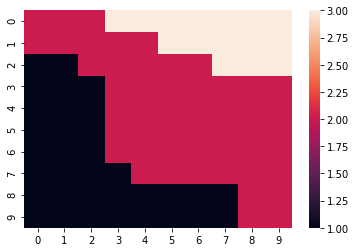

In [8]:
n = 3
discretized_planes = []

for component_plane in component_planes:
    bins = np.linspace(component_plane.min(), component_plane.max(), n, False)
    discretized_plane = np.digitize(component_plane, bins)
    discretized_planes.append(discretized_plane)

sns.heatmap(discretized_planes[0])

### 3. Component Lines (Fi)

Based on the algorith of NEU07_ijcnn, the following steps need to be performed:
For each component, take a region (bins) and check which points fall within the interval of the region. Sum the values up, and divide the sum by the number of points in the region. The result is the gravity center of a component's region. Repeat these steps for all regions.

In [27]:
def calculate_region_center(points):
    return sum(points) / len(points)


def get_points_inside_region(region, component):
    return np.argwhere(component == region)


def get_region_centers(component):
    region_centers = []
    for region_index in range(n):
        region = region_index + 1
        included_points = get_points_inside_region(region, component)
        region_center = calculate_region_center(included_points)
        region_centers.append(region_center)
    return region_centers


def get_component_lines(binned_planes):
    """ returns e.g., [[[1,2], [3,4], [3,5]], [...], [...]] -> component plane 0 has line with points: (1,2), (3,4) (3,5)"""
    lines = []
    for component in binned_planes:
        region_centers = get_region_centers(component)
        lines.append(region_centers)
    return lines


def get_min_max_lines(lines):
    """ returns e.g., [[3.5, 8.9], [...], [...]] -> component plane 0 (line 0) has min at 3.5 and max at 8.9 """
    return [[np.min(points), np.max(points)] for points in lines]


lines = np.array(get_component_lines(discretized_planes))
lines_min_max = get_min_max_lines(lines)

lines
lines_min_max

[[0.7333333333333333, 6.733333333333333],
 [0.7272727272727273, 6.722222222222222],
 [1.1290322580645162, 7.413793103448276],
 [1.1290322580645162, 7.483870967741935]]

## Metro Map Visualization

### 4. Visualization

Connect the centers with lines

[[[6.52941176 2.20588235]
  [4.25490196 5.37254902]
  [0.73333333 6.73333333]]

 [[6.72222222 6.33333333]
  [3.52830189 4.03773585]
  [1.90909091 0.72727273]]

 [[5.09677419 1.12903226]
  [5.375      5.        ]
  [2.65517241 7.4137931 ]]

 [[5.09677419 1.12903226]
  [5.18421053 4.81578947]
  [3.06451613 7.48387097]]]


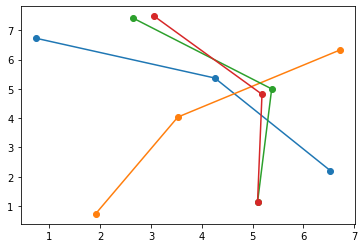

In [24]:
print(lines)

for line in lines:
    x_coordinates = [point[0] for point in line]
    y_coordinates = [point[1] for point in line]
    plt.plot(x_coordinates, y_coordinates, '-o')

plt.show()

### 5. Aggregation (FL)

distance-based

Take pair wise lines,
    calculate distance between two lines:
        same_idx_dist <- sum of distances between pairs of centers of same indices
        inv_idx_dist <- sum of distances between paris of centers of inverted indices
        dist <- min(same_idx_dist, inv_idx_dist)

use Ward's clustering (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html)



### 6. Selection

See Algorithm 1 (NEU07_wsom paper)
select only components with a small amount of regions per bin



### 7. Snapping

See Algorithm 1 (https://github.com/yozoon/SOM-MetroMap/blob/main/implementation_report.pdf)

See implementation of template method `_find_snapped_line`



## References